<a href="https://colab.research.google.com/github/JiHoonPark96/practice/blob/main/STAT492_Assignment12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Scrape S&P 500 company information
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table", {"id": "constituents"})

# Parse table data
rows = table.find_all("tr")[1:]
data = []
for row in rows:
    cells = row.find_all("td")
    ticker = cells[0].text.strip()
    name = cells[1].text.strip()
    industry = cells[3].text.strip()
    data.append({"Ticker": ticker, "Name": name, "Industry": industry})

# Save to CSV
sp500_df = pd.DataFrame(data)
sp500_df.to_csv("sp500_companies.csv", index=False)
print("S&P 500 data saved to sp500_companies.csv")


S&P 500 data saved to sp500_companies.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Stock price data saved to sp500_prices.csv


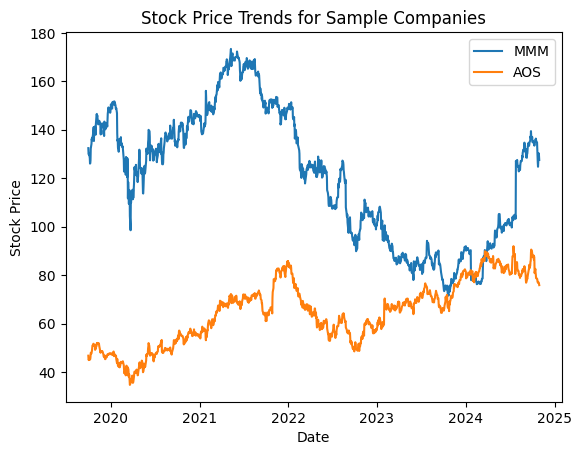

In [2]:
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Load S&P 500 tickers
sp500_df = pd.read_csv("sp500_companies.csv")
tickers = sp500_df["Ticker"].tolist()

# Set date range
start_date = "2019-10-01"
end_date = "2024-10-31"

# Download stock price data
price_data = {}
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if len(stock_data) == 0:
            continue
        price_data[ticker] = stock_data
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")

# Combine all data into a single DataFrame
all_data = pd.concat({ticker: df["Close"] for ticker, df in price_data.items()}, axis=1)
all_data.to_csv("sp500_prices.csv")
print("Stock price data saved to sp500_prices.csv")

# Plotting example stock trends
sample_tickers = list(price_data.keys())[:2]  # First two tickers
for ticker in sample_tickers:
    plt.plot(price_data[ticker].index, price_data[ticker]["Close"], label=ticker)
plt.legend()
plt.title("Stock Price Trends for Sample Companies")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()


In [13]:
import pandas as pd

# Load the data
prices_path = "/content/sp500_prices.csv"
companies_path = "/content/sp500_companies.csv"

# Skip the first row if it's a duplicate header
prices_df = pd.read_csv(prices_path, index_col=0, skiprows=1)

# Convert index to datetime
prices_df.index = pd.to_datetime(prices_df.index, errors="coerce")

# Drop rows with invalid datetime indexes (where the index is NaT)
prices_df = prices_df[prices_df.index.notnull()] # Changed this line to filter by index instead of using dropna with subset

# Load companies data
companies_df = pd.read_csv(companies_path)

# Display first few rows to confirm proper loading
print(prices_df.head())
print(companies_df.head())

                                  MMM        AOS        ABT       ABBV  \
Ticker                                                                   
2019-10-01 00:00:00+00:00  132.424744  46.810001  81.839996  73.230003   
2019-10-02 00:00:00+00:00  130.142136  45.189999  79.529999  72.129997   
2019-10-03 00:00:00+00:00  129.790970  45.000000  81.070000  73.849998   
2019-10-04 00:00:00+00:00  130.284286  45.509998  81.989998  74.660004   
2019-10-07 00:00:00+00:00  128.361206  45.130001  81.040001  74.330002   

                                  ACN        ADBE        AMD        AES  \
Ticker                                                                    
2019-10-01 00:00:00+00:00  189.619995  272.709991  28.760000  16.240000   
2019-10-02 00:00:00+00:00  184.850006  266.660004  28.309999  15.700000   
2019-10-03 00:00:00+00:00  185.809998  272.399994  28.680000  15.800000   
2019-10-04 00:00:00+00:00  189.639999  276.959991  29.010000  16.030001   
2019-10-07 00:00:00+00:00  186.

<ipython-input-13-3f7cd4194a38>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices_df.index = pd.to_datetime(prices_df.index, errors="coerce")


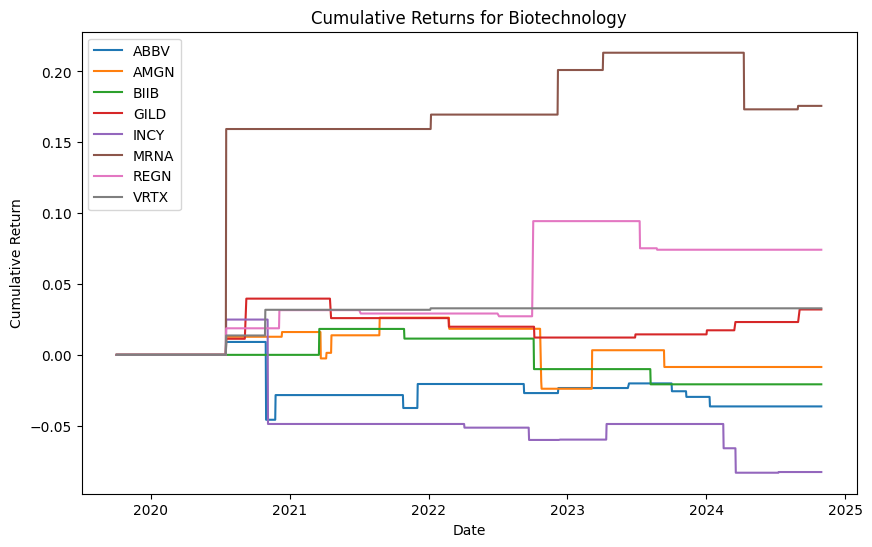

In [14]:
# Simple Moving Average (SMA) Crossover Strategy
def sma_crossover(prices, short_window=50, long_window=200):
    signals = pd.DataFrame(index=prices.index)
    signals['Price'] = prices
    signals['Short_MA'] = prices.rolling(window=short_window).mean()
    signals['Long_MA'] = prices.rolling(window=long_window).mean()
    signals['Signal'] = np.where(signals['Short_MA'] > signals['Long_MA'], 1, 0)
    signals['Position'] = signals['Signal'].diff()
    return signals

# Apply to one industry
selected_industry = 'Biotechnology'
selected_tickers = companies_df[companies_df['Industry'] == selected_industry]['Ticker']

returns = {}
for ticker in selected_tickers:
    if ticker in prices_df.columns:
        signals = sma_crossover(prices_df[ticker])
        signals['Daily_Return'] = prices_df[ticker].pct_change()
        signals['Strategy_Return'] = signals['Position'].shift(1) * signals['Daily_Return']
        returns[ticker] = signals['Strategy_Return'].cumsum()  # Cumulative returns

# Plot cumulative returns
plt.figure(figsize=(10, 6))
for ticker, cumulative_returns in returns.items():
    plt.plot(cumulative_returns.index, cumulative_returns, label=ticker)
plt.title(f"Cumulative Returns for {selected_industry}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


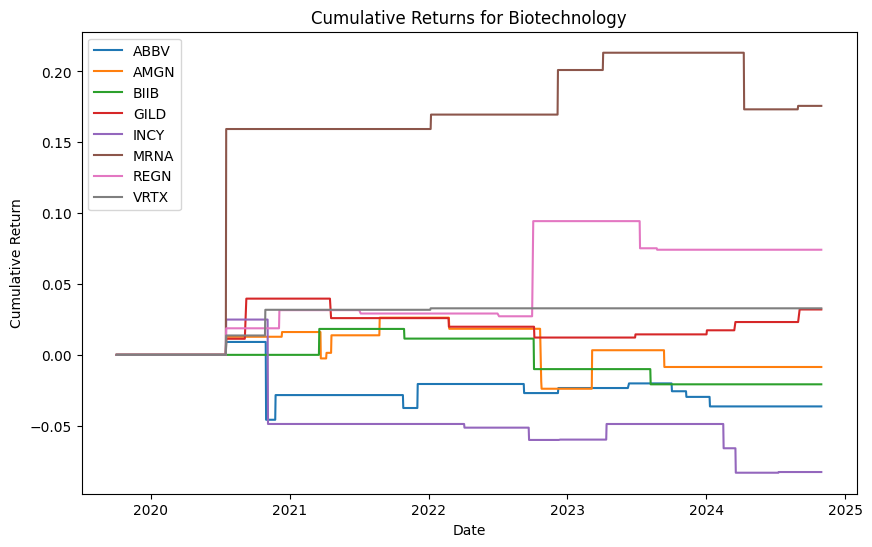

In [15]:
# Simple Moving Average (SMA) Crossover Strategy
def sma_crossover(prices, short_window=50, long_window=200):
    signals = pd.DataFrame(index=prices.index)
    signals['Price'] = prices
    signals['Short_MA'] = prices.rolling(window=short_window).mean()
    signals['Long_MA'] = prices.rolling(window=long_window).mean()
    signals['Signal'] = np.where(signals['Short_MA'] > signals['Long_MA'], 1, 0)
    signals['Position'] = signals['Signal'].diff()
    return signals

# Apply to one industry
selected_industry = 'Biotechnology'
selected_tickers = companies_df[companies_df['Industry'] == selected_industry]['Ticker']

returns = {}
for ticker in selected_tickers:
    if ticker in prices_df.columns:
        signals = sma_crossover(prices_df[ticker])
        signals['Daily_Return'] = prices_df[ticker].pct_change()
        signals['Strategy_Return'] = signals['Position'].shift(1) * signals['Daily_Return']
        returns[ticker] = signals['Strategy_Return'].cumsum()  # Cumulative returns

# Plot cumulative returns
plt.figure(figsize=(10, 6))
for ticker, cumulative_returns in returns.items():
    plt.plot(cumulative_returns.index, cumulative_returns, label=ticker)
plt.title(f"Cumulative Returns for {selected_industry}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


In [16]:
# Identify bullish patterns (e.g., SMA Crossover)
bullish_stocks = []

for ticker in prices_df.columns:
    signals = sma_crossover(prices_df[ticker])
    if signals['Position'].iloc[-1] == 1:  # Last position is a buy signal
        bullish_stocks.append(ticker)

print(f"Bullish stocks: {bullish_stocks}")


Bullish stocks: ['CMG', 'DAY']


Skipping industry Multi-Sector Holdings due to no matching tickers in price data.


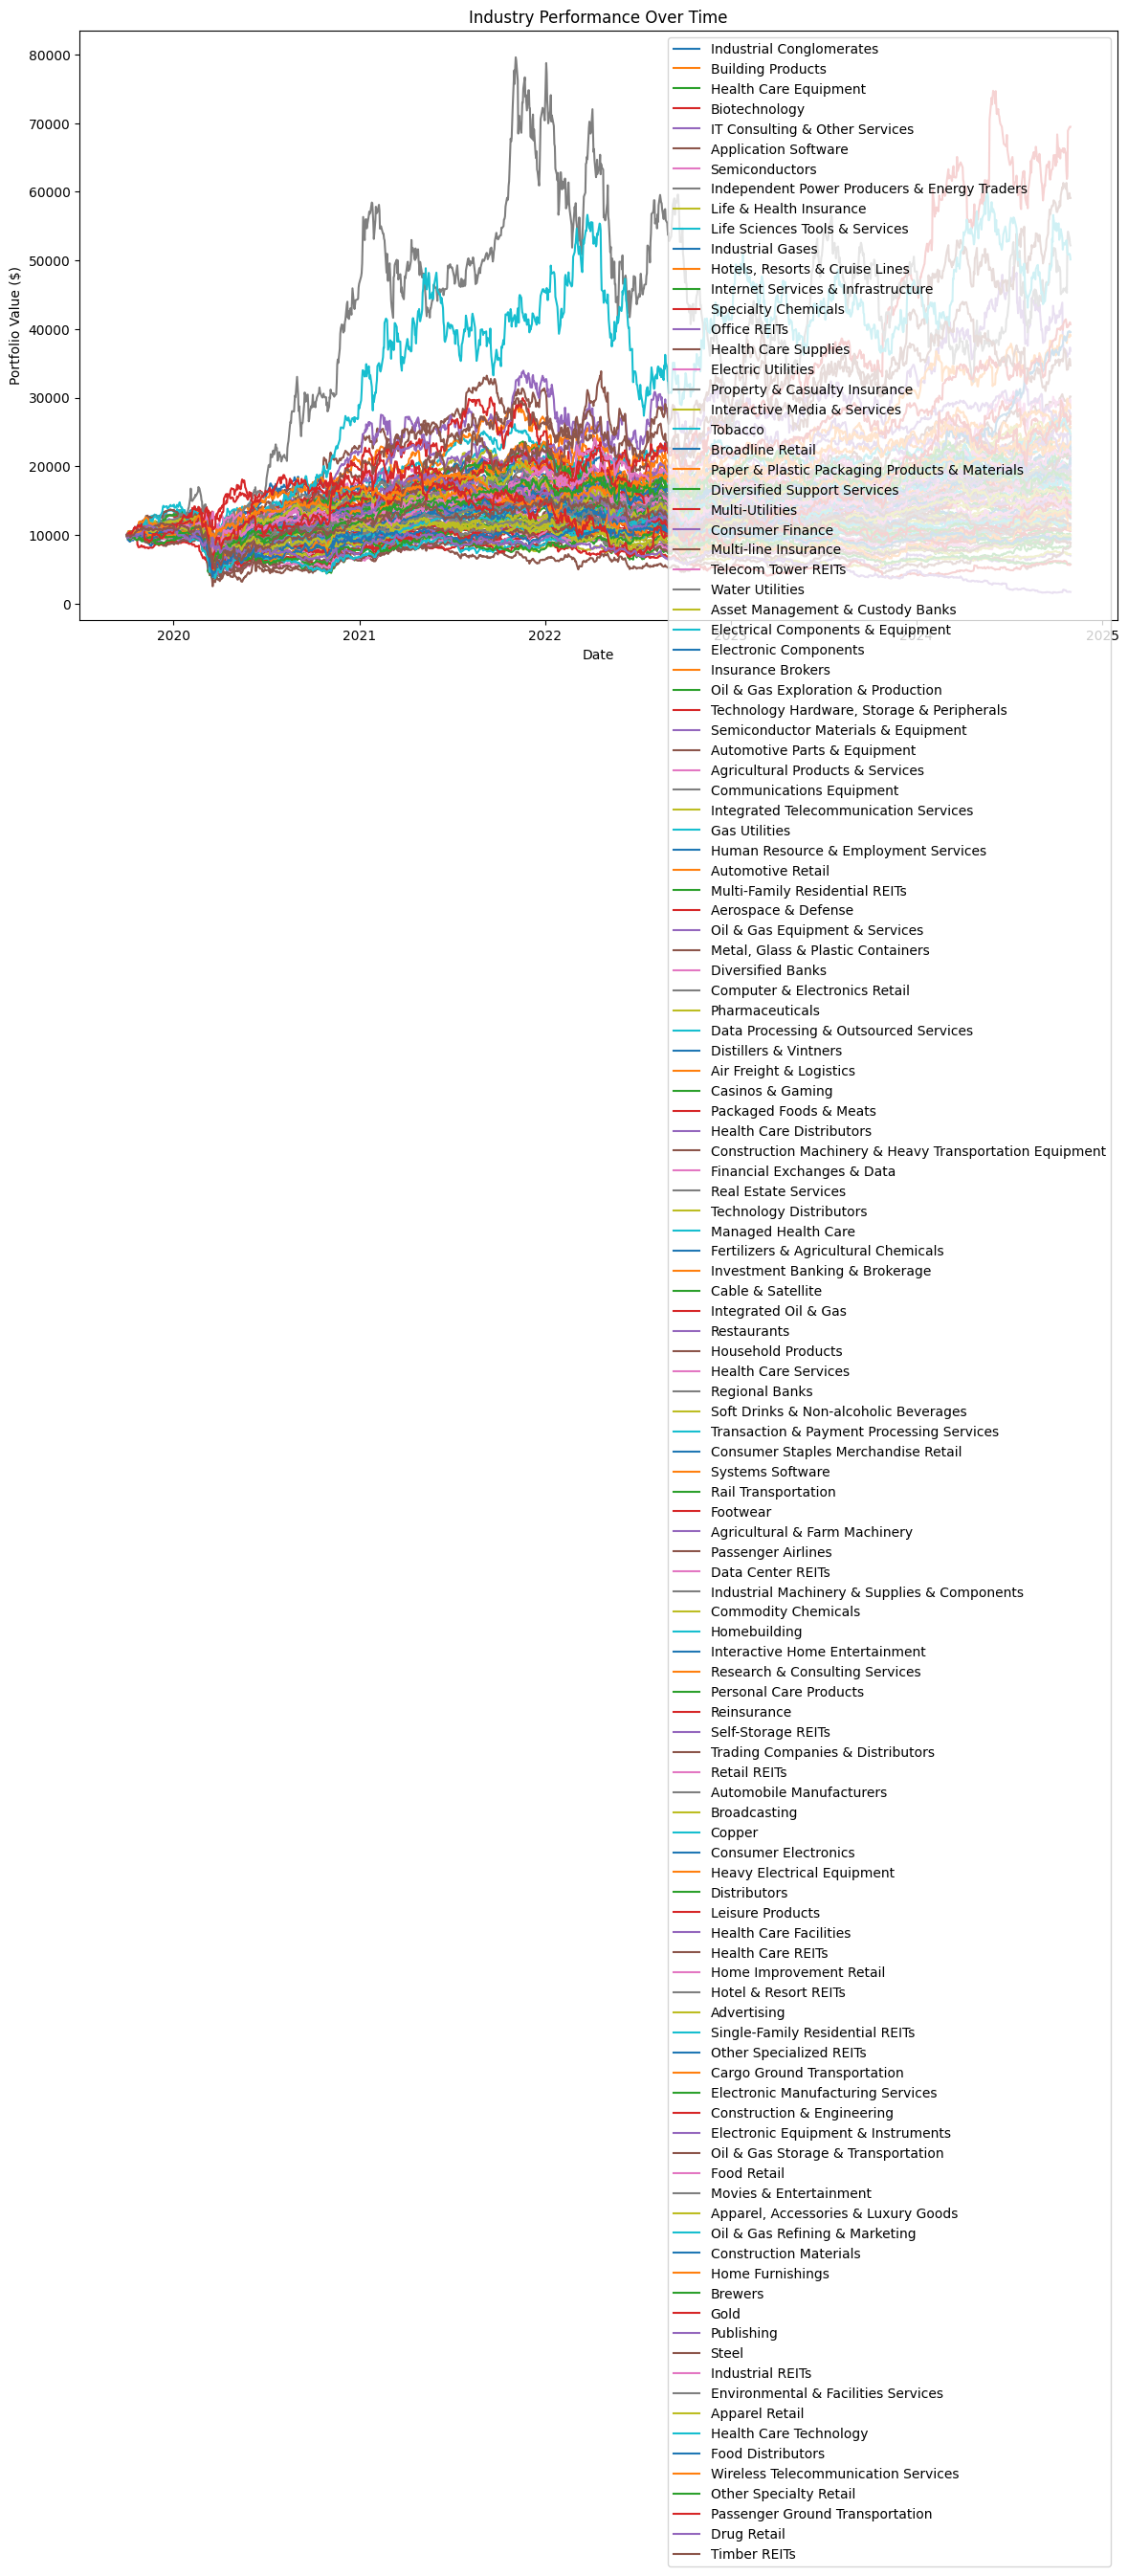

In [18]:
# Calculate industry performance
initial_investment = 10000

industry_performance = {}

for industry in companies_df['Industry'].unique():
    tickers = companies_df[companies_df['Industry'] == industry]['Ticker']
    # Filter tickers to only include those present in prices_df
    valid_tickers = tickers[tickers.isin(prices_df.columns)]
    # If no valid tickers, skip to next industry
    if len(valid_tickers) == 0:
        print(f"Skipping industry {industry} due to no matching tickers in price data.")
        continue
    industry_prices = prices_df[valid_tickers].mean(axis=1)  # Equal investment in all stocks
    normalized_prices = industry_prices / industry_prices.iloc[0]  # Normalize to start at 1
    industry_performance[industry] = normalized_prices * initial_investment

# Plot industry performance
plt.figure(figsize=(14, 8))
for industry, performance in industry_performance.items():
    plt.plot(performance.index, performance, label=industry)
plt.title("Industry Performance Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

Skipping industry Multi-Sector Holdings due to no matching tickers in price data.


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


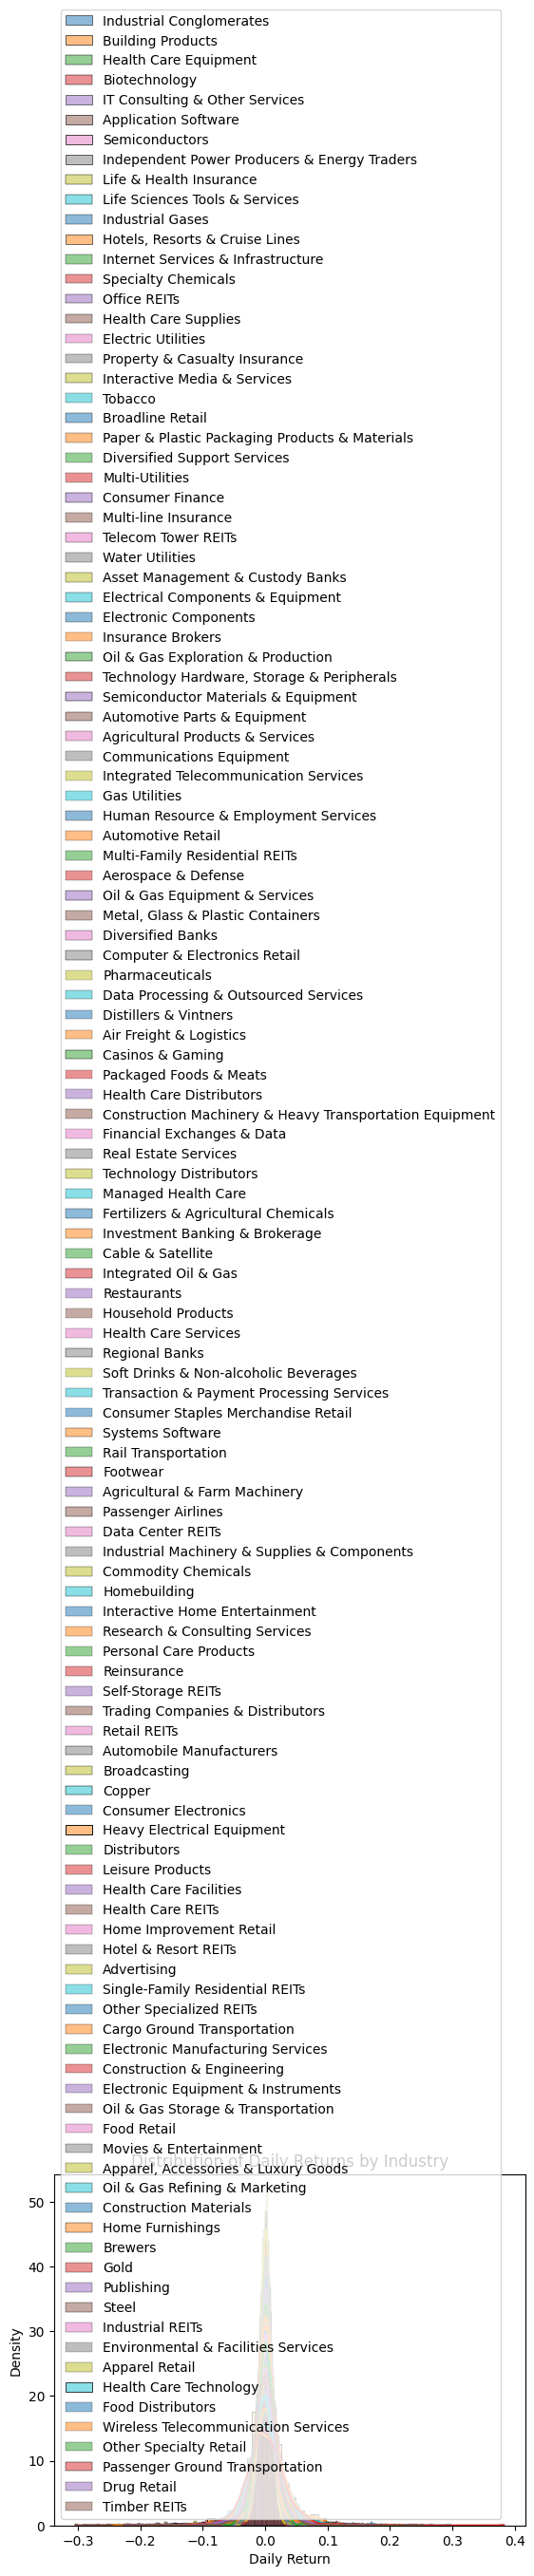

In [20]:
daily_returns = prices_df.pct_change()
industry_returns = {}

for industry in companies_df['Industry'].unique():
    tickers = companies_df[companies_df['Industry'] == industry]['Ticker']
    # Filter tickers to only include those present in daily_returns columns
    valid_tickers = tickers[tickers.isin(daily_returns.columns)]
    # If no valid tickers, skip to next industry
    if len(valid_tickers) == 0:
        print(f"Skipping industry {industry} due to no matching tickers in price data.")
        continue
    industry_returns[industry] = daily_returns[valid_tickers].mean(axis=1)  # Mean daily return

# Plot distribution of daily returns
for industry, returns in industry_returns.items():
    sns.histplot(returns.dropna(), kde=True, label=industry, stat="density")
plt.legend()
plt.title("Distribution of Daily Returns by Industry")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.show()

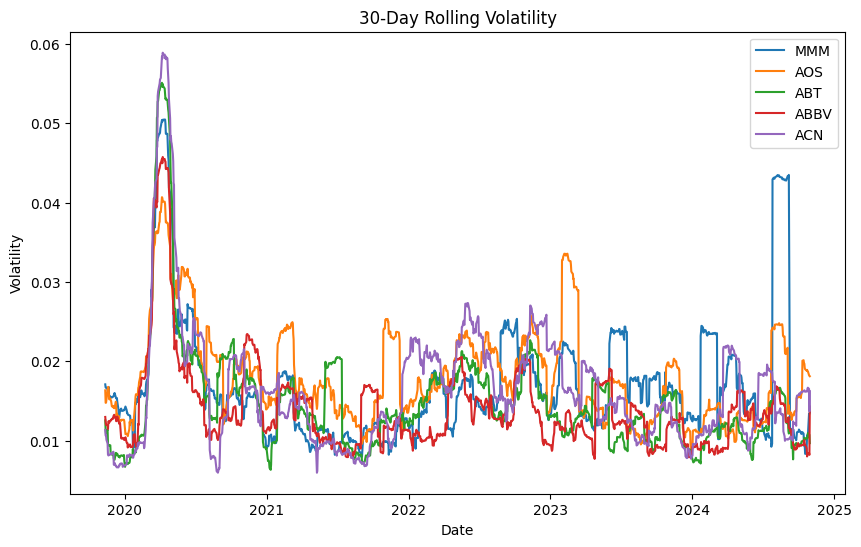

In [21]:
# Calculate rolling volatility
volatility = prices_df.pct_change().rolling(window=30).std()

# Plot volatility for selected stocks
selected_stocks = prices_df.columns[:5]  # First 5 stocks for illustration
plt.figure(figsize=(10, 6))
for ticker in selected_stocks:
    plt.plot(volatility.index, volatility[ticker], label=ticker)
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()
